In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Visualisation for Yields:
### Density of Crop data by municipality 

In [30]:
df_yields = pd.read_csv("./data/Yields.csv")
df_weather = pd.read_csv("./data/Weather Reanalysis.csv")

n_crops = df_yields["Crop"].nunique(dropna=True)
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different crops: {n_crops}") # 53 crops expected
print(f"- number of different municipalities in df_yields: {n_munis}") # 99 municipalities expected

n_munis = df_weather["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities in df_weather: {n_munis}") # 84 municipalities expected

# filter df_yields to contain the same municipalitys as in df_weather
munis_weather = df_weather["Municipality"].unique()
df_yields = df_yields[df_yields["Municipality"].isin(munis_weather)]
n_munis = df_yields["Municipality"].nunique(dropna=True)
print(f"- number of different municipalities after filtering: {n_munis}")


- number of different crops: 53
- number of different municipalities in df_yields: 99
- number of different municipalities in df_weather: 84
- number of different municipalities after filtering: 84


In [31]:
def crop_sum_density_df(df_yields: pd.DataFrame) -> pd.DataFrame:
    df = df_yields.copy()
    df["crop_sum"] = df.groupby(["Municipality", "Crop"])["Year"].transform("size")
    return (df[["Municipality", "Crop", "crop_sum"]]
            .drop_duplicates()
            .reset_index(drop=True))

# Plot heatmap Municipality vs Crop using crop_sum as “temperature”
def plot_density_heatmap(density_df: pd.DataFrame, title="Density (#rows) by Municipality × Crop"):
    pivot = density_df.pivot(index="Crop", columns="Municipality", values="crop_sum").fillna(0)

    fig_w = max(10, pivot.shape[1] * 0.35)
    fig_h = max(6,  pivot.shape[0] * 0.35)
    fig, ax = plt.subplots(figsize=(fig_w, fig_h))

    im = ax.imshow(pivot.values, aspect="auto", cmap="viridis")
    ax.set_xticks(np.arange(pivot.shape[1]))
    ax.set_yticks(np.arange(pivot.shape[0]))
    ax.set_xticklabels(pivot.columns, rotation=90)
    ax.set_yticklabels(pivot.index)
    ax.set_xlabel("Municipality")
    ax.set_ylabel("Crop")
    ax.set_title(title)

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("crop_sum (#rows per Municipality×Crop)")

    plt.tight_layout()
    plt.show()

def drop_low_municipalities(density_df: pd.DataFrame, percent: float) -> pd.DataFrame:
    """
    Keep municipalities whose BEST crop (max crop_sum over crops) is not in the bottom `percent`.
    """
    muni_peaks = density_df.groupby("Municipality")["crop_sum"].max()

    threshold = muni_peaks.quantile(percent / 100.0)

    keep = muni_peaks[muni_peaks > threshold].index
    return density_df[density_df["Municipality"].isin(keep)].copy()


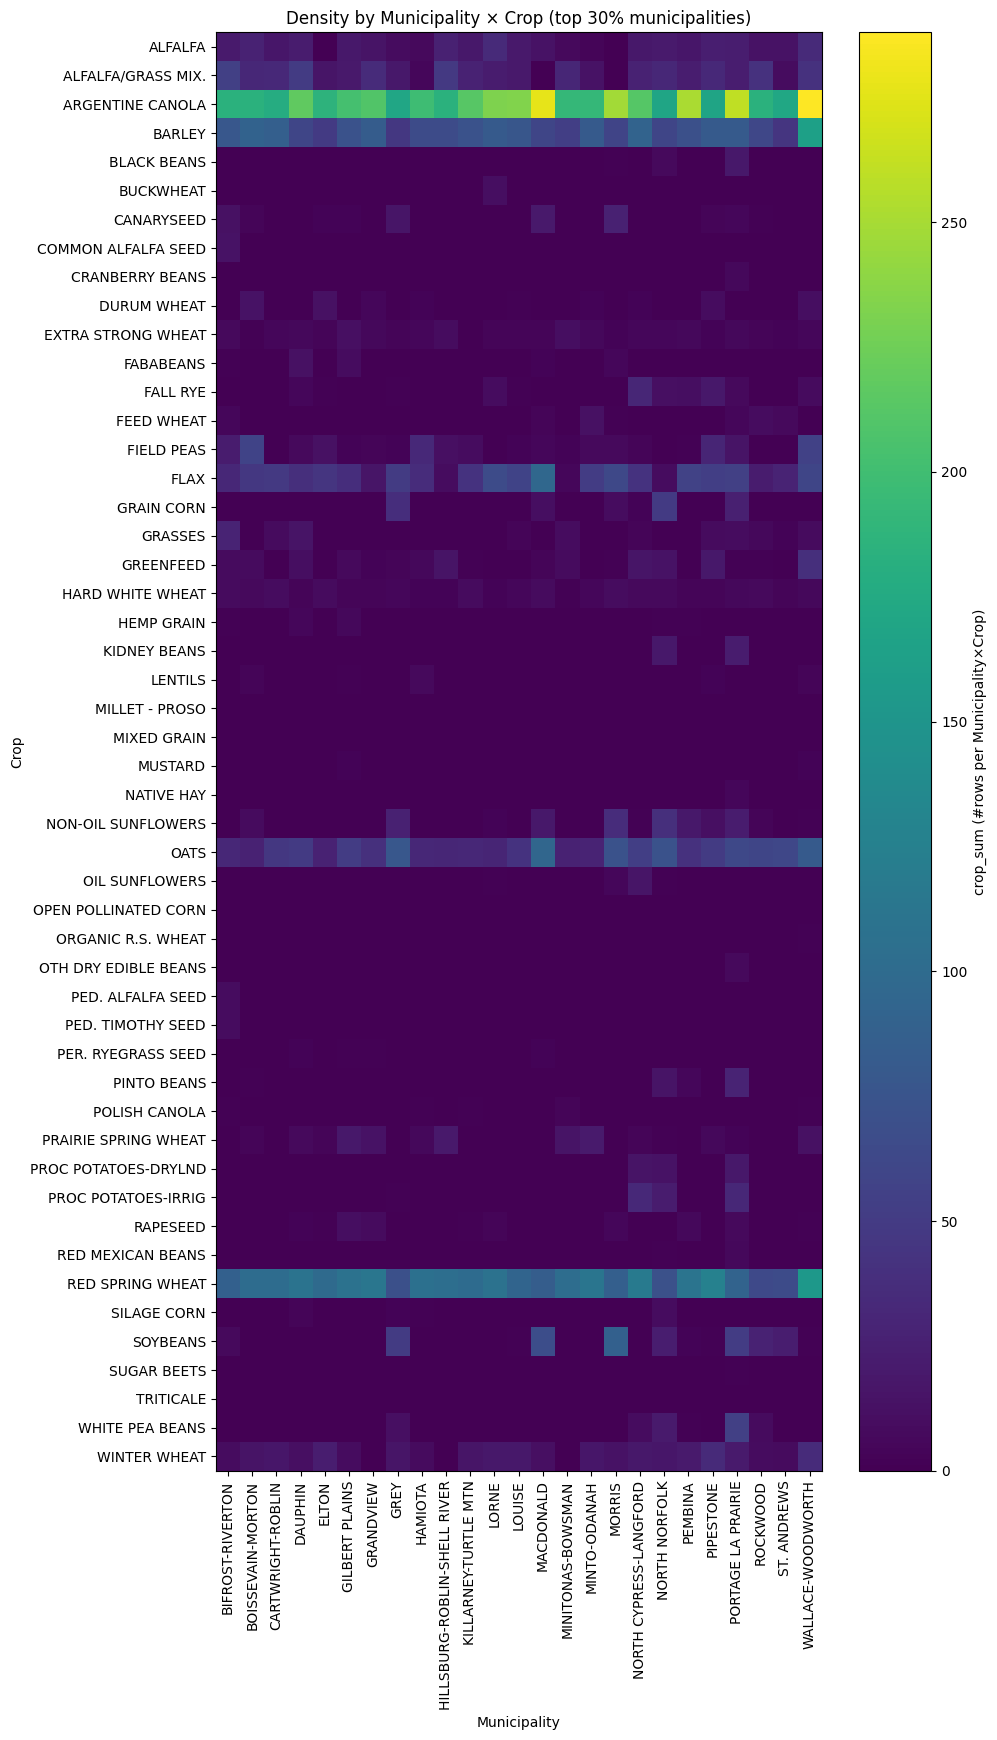

In [32]:
density_df = crop_sum_density_df(df_yields)

density_df_top = drop_low_municipalities(density_df, percent=70)

plot_density_heatmap(density_df_top, title="Density by Municipality × Crop (top 30% municipalities)")